## Importing the goodies 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.utils import shuffle
from scipy.signal import resample
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.ndimage.filters import gaussian_filter1d   ## smoother

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

# calculate train time, writing train data to files etc.
import time
import pandas as pd
from IPython.display import clear_output
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data.dataset import random_split



## Loading up the raw data 
* Converting CSV files to Pandas dataframe
* And concatenating the train and test set to a single Pandas dataframe

In [2]:
df1=pd.read_csv('storage/mitbih_train.csv',header=None)
df2=pd.read_csv('storage/mitbih_test.csv',header=None)

df = pd.concat([df1,df2], axis = 0)

## Visualising the class wise frequency distribution
* Which pretty much says that the dataset is unbalanced and needs some balancing using some form of augmentation


0    90589
4     8039
2     7236
1     2779
3      803
Name: 187, dtype: int64


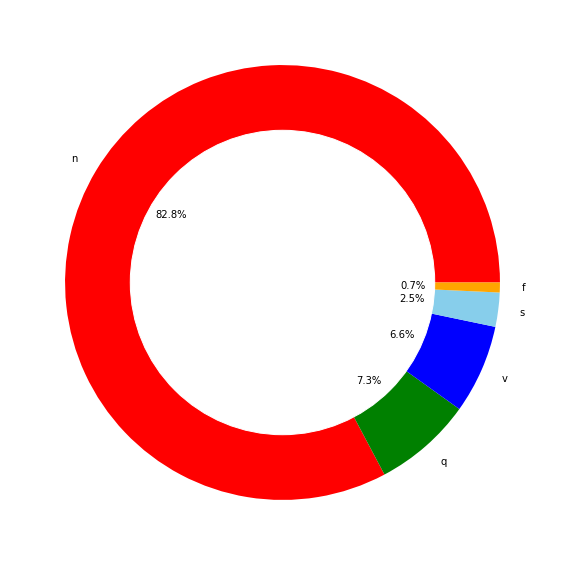

In [3]:

df[187]=df[187].astype(int)
equilibre=df[187].value_counts()
print(equilibre)

plt.figure(figsize=(10,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()



In [4]:
def extract_row(df, row_index):
    seg = []
    for  i in df.iloc[row_index]:
        seg.append(i)
    return seg

## Visualising a sample from the first and the last class of data
* They look pretty different, different enough for a deep neural network to understand and make predictions 

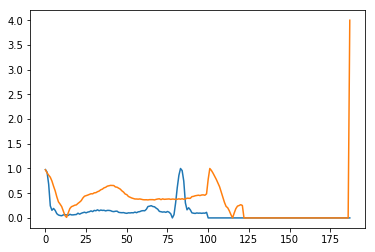

In [5]:
plt.plot(extract_row(df,0))
plt.plot(extract_row(df,-1))
plt.show()

## Converting the dataframe into two numpy arrays containing labels and images
* Labels were the last element of each row so some fancy slicng was used to extract them into another array.

In [6]:
M = df.values
X = M[:, :-1] ## all columns until last column 
y = M[:, -1].astype(int)  ## last column

##  Obtaining a list of the indices of occurrences of each label 
* `np.argwhere()` =  returns an array of indices which satisfies a certain condition
*  had to squeeze it to remove the square bracket from each returned index

In [7]:
C0 = np.argwhere(y == 0).flatten()
C1 = np.argwhere(y == 1).flatten()
C2 = np.argwhere(y == 2).flatten()
C3 = np.argwhere(y == 3).flatten()
C4 = np.argwhere(y == 4).flatten()

# Plotting a sample of each category

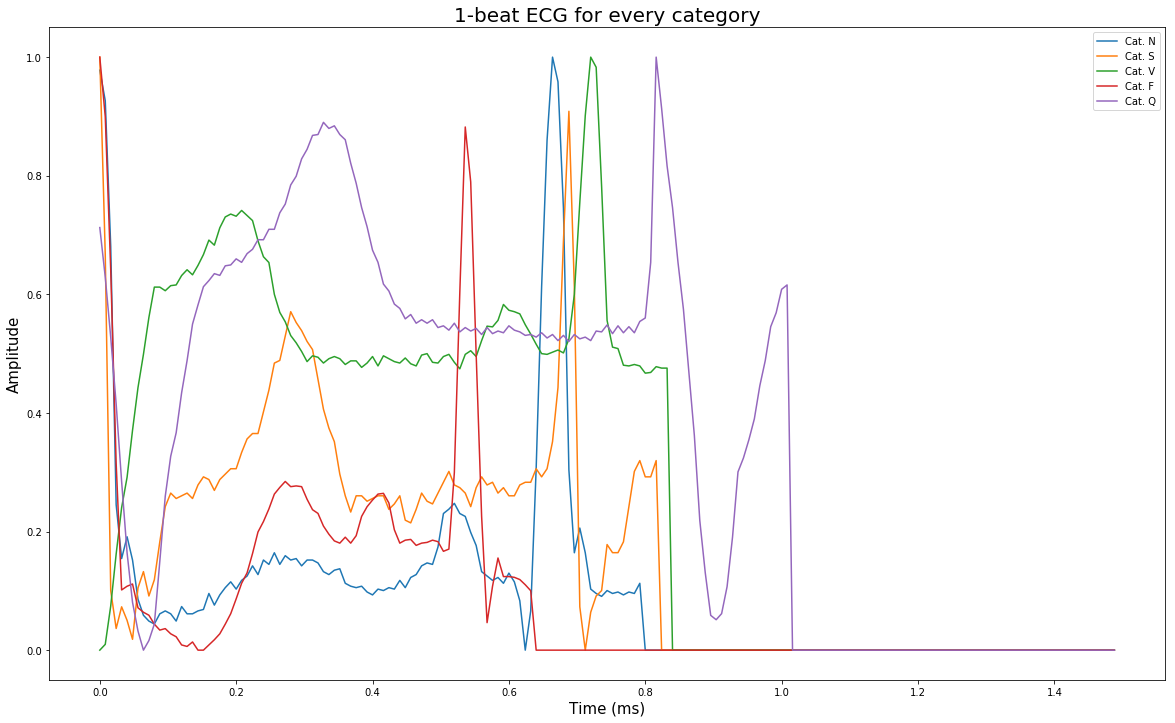

In [8]:
x = np.arange(0, 187)*8/1000

plt.figure(figsize=(20,12))
plt.plot(x, X[C0, :][0], label="Cat. N")
plt.plot(x, X[C1, :][0], label="Cat. S")
plt.plot(x, X[C2, :][0], label="Cat. V")
plt.plot(x, X[C3, :][0], label="Cat. F")
plt.plot(x, X[C4, :][0], label="Cat. Q")
plt.legend()
plt.title("1-beat ECG for every category", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

## Defining some functions for data augmentation
* `strech()` causes random horizontal displacements in sample graph plots 

* `amplify()` causes random vertical displacements in the sample, while keeping horizontal values intact

In [10]:
def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

def augment(x):
    result = np.zeros(shape= (4, 187))
    for i in range(3):
        if random.random() < 0.33:
            new_y = stretch(x)
        elif random.random() < 0.66:
            new_y = amplify(x)
        else:
            new_y = stretch(x)
            new_y = amplify(new_y)
        result[i, :] = new_y
    return result

## Checking how augmented data looks like on a sample 
* Blue is the original one
* Orange is amplified
* Green is streched

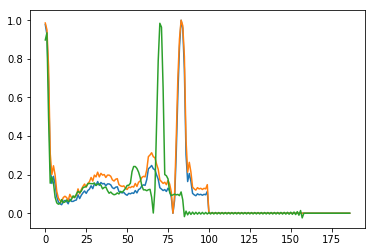

In [11]:
plt.plot(X[0, :])
plt.plot(amplify(X[0, :]))
plt.plot(stretch(X[0, :]))
plt.show()

## Augmenting and preparing the training data before it gets into a PyTorch wrapper

In [12]:
result = np.apply_along_axis(augment, axis=1, arr=X[C3]).reshape(-1, 187)
classe = np.ones(shape=(result.shape[0],), dtype=int)*3
X = np.vstack([X, result])
y = np.hstack([y, classe])

In [13]:
subC0 = np.random.choice(C0, 800)
subC1 = np.random.choice(C1, 800)
subC2 = np.random.choice(C2, 800)
subC3 = np.random.choice(C3, 800)
subC4 = np.random.choice(C4, 800)

## Splitting the training data into training and validation sets
* And then shufling them to prevent biases in the start of the training
* Also viewing the lengths (more like shapes) of the prepared datasets

In [14]:
x_test = np.vstack([X[subC0], X[subC1], X[subC2], X[subC3], X[subC4]])
y_test = np.hstack([y[subC0], y[subC1], y[subC2], y[subC3], y[subC4]])

x_train = np.delete(X, [subC0, subC1, subC2, subC3, subC4], axis=0)
y_train = np.delete(y, [subC0, subC1, subC2, subC3, subC4], axis=0)

x_train, y_train = shuffle(x_train, y_train, random_state=0)
x_test, y_test = shuffle(x_test, y_test, random_state=0)


In [15]:
print("X_train", x_train.shape)
print("y_train", y_train.shape)
print("X_test", x_test.shape)
print("y_test", y_test.shape)


X_train (109109, 187)
y_train (109109,)
X_test (4000, 187)
y_test (4000,)


## Using the TensorDataset wrapper over the dataset and making an 80-20 split
* And creating a smaller slice from the validation set for benchmarking the NN after trainng 


In [16]:
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

full_dataset = TensorDataset(x_train_tensor, y_train_tensor)    ## make compatible with DataLoader 


train_size = int(0.8 * len(full_dataset))  ## 90/10 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

test_size = int(0.8 * len(test_dataset))
benchmark_size = len(test_dataset) - test_size
test_dataset, benchmark_dataset = random_split(test_dataset, [test_size, benchmark_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)

val_loader = DataLoader(dataset=test_dataset, batch_size=10, shuffle = True)

benchmark_loader =  DataLoader(dataset=benchmark_dataset, batch_size=1, shuffle = True)



print(len(train_loader), "batches ")
print(len(val_loader), " batches ")
print(len(benchmark_loader), " batches")

2183 batches 
1746  batches 
4365  batches


In [17]:
def vis_loss_multi_colors(loss_arr,val_arr):
    
    ysmoothed = gaussian_filter1d(loss_arr, sigma=3)
    plt.plot( ysmoothed, "c", label = "training")
    ysmoothed2 = gaussian_filter1d(val_arr, sigma=7)
    plt.plot(ysmoothed2, "g", label = "validation")
    
    plt.ylabel("Loss", fontsize=15)
    plt.xlabel("batches", fontsize=15)
    plt.show()

## defining the NN layers
* all linear layers, slowly converging to return the label value
* might try one hot encodings as well

In [18]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(187, 180, 5)
        self.fc2 = nn.Linear(180, 180, 5)
        self.fc3 = nn.Linear(180, 140, 5)

        self.fc4 = nn.Linear(140, 100, 5)
        self.fc5 = nn.Linear(100, 50, 5)
        self.fc6 = nn.Linear(50, 1, 5)



    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))


        return (self.fc6(x))
    
ECGNet = Model()
print(ECGNet)

Model(
  (fc1): Linear(in_features=187, out_features=180, bias=True)
  (fc2): Linear(in_features=180, out_features=180, bias=True)
  (fc3): Linear(in_features=180, out_features=140, bias=True)
  (fc4): Linear(in_features=140, out_features=100, bias=True)
  (fc5): Linear(in_features=100, out_features=50, bias=True)
  (fc6): Linear(in_features=50, out_features=1, bias=True)
)


## Initiating hyperparameters and some lists to collect training stats 
* the scheduler helps reduce random loss spikes after quite a few epochs of trainng by slowly reducing the learning rate as each epoch passes 

In [79]:
optimizer = optim.Adam(ECGNet.parameters(), lr = 0.001) 
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)  # lr decreases by 10% aftr every epoch
losses = []
val_losses = []
accuracies = []

## Defining the benchmarking code, a single train step, and the main training loop
*  The single training kind of helps make things cleaner on the training loop and makes playing with different loss functions easier, making it more recyclable and readable.
* MSE loss was the best option since this is a regression model

In [80]:
def calculate_accuracy_on_validation_set(val_loader):
    print("running benchmark...")
    with torch.no_grad():
        total = 0
        correct = 0
        for x_val, y_val in val_loader:
            total+= 1 
            y_val =  y_val.unsqueeze(1)
            y_val =  y_val.float()
            pred = ECGNet(x_val)  # pred 
            if -0.4 < (pred.item() - y_val.item())< 0.4:
                correct +=1 
        acc = (correct/total)*100
        return acc
    
    
def train_step(x, y):
        optimizer.zero_grad()
        pred = ECGNet(x)
        y = y.unsqueeze(1)
        y = y.float()
        loss = F.mse_loss(pred, y)
        loss.backward()
        optimizer.step()
        return loss.item()

def train(epochs):
    
    for m in range (epochs):
        clear_output()
        print ("epoch ", m+1, " out of ", epochs )
        ECGNet.train()
        for x_batch, y_batch in train_loader:


                loss = train_step(x_batch, y_batch)
                losses.append(loss)
        scheduler.step()   ## lr decay caller 

        with torch.no_grad():
                ECGNet.eval()

                for x_val, y_val in val_loader:
                    y_val =  y_val.unsqueeze(1)
                    y_val =  y_val.float()

                    yhat = ECGNet(x_val)  # pred 
                    val_loss = F.mse_loss(yhat, y_val)

                    val_losses.append(val_loss.item())  ## metrics 
        
        accuracies.append(calculate_accuracy_on_validation_set(benchmark_loader))
    plt.plot(accuracies)
    plt.xlabel("epochs", fontsize = 15)
    plt.ylabel("accuracy", fontsize=15)
    plt.show()
    print ("Final accuracy = ", accuracies[-1], " %")

epoch  15  out of  15
running benchmark...


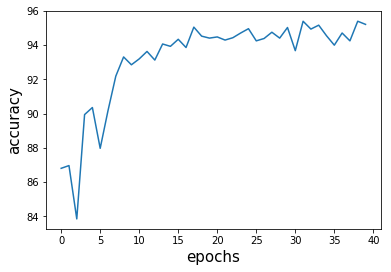

Final accuracy =  95.21300961978928  %


In [82]:
train(15)

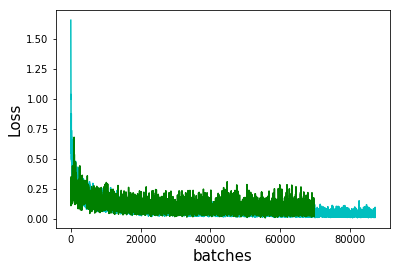

In [83]:
vis_loss_multi_colors(losses, val_losses)

In [84]:
print ("Accuracy = ", calculate_accuracy_on_validation_set(benchmark_loader), " %")

running benchmark...
Accuracy =  95.21300961978928  %
